In [1]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,f1_score
#https://www.kaggle.com/c/DontGetKicked

# 1. Data Cleaning

In this first section we will:
1)Load the data
2) Explore the data types, adjust as needed
3) Checking missing values, and handle them

In [2]:
#loading in training data
full_training=pd.read_csv('training.csv')

In [3]:
#loading in test set.
#note, doing this after modeling is complete, but doing the feature manipulation along side the manipulation of the training
#set for simplicity. If there were more time I would re-write all this proprocessing into a function/pipeline, to eliminate
#the code duplication
full_test=pd.read_csv('test.csv')

In [4]:
full_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   RefId                              72983 non-null  int64  
 1   IsBadBuy                           72983 non-null  int64  
 2   PurchDate                          72983 non-null  object 
 3   Auction                            72983 non-null  object 
 4   VehYear                            72983 non-null  int64  
 5   VehicleAge                         72983 non-null  int64  
 6   Make                               72983 non-null  object 
 7   Model                              72983 non-null  object 
 8   Trim                               70623 non-null  object 
 9   SubModel                           72975 non-null  object 
 10  Color                              72975 non-null  object 
 11  Transmission                       72974 non-null  obj

In [5]:
full_features=full_training.drop(columns=['RefId','IsBadBuy'])
full_y=full_training['IsBadBuy']
test_features=full_test.drop(columns=['RefId'])

In [6]:
full_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48707 entries, 0 to 48706
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   RefId                              48707 non-null  int64  
 1   PurchDate                          48707 non-null  object 
 2   Auction                            48707 non-null  object 
 3   VehYear                            48707 non-null  int64  
 4   VehicleAge                         48707 non-null  int64  
 5   Make                               48707 non-null  object 
 6   Model                              48707 non-null  object 
 7   Trim                               47157 non-null  object 
 8   SubModel                           48702 non-null  object 
 9   Color                              48703 non-null  object 
 10  Transmission                       48704 non-null  object 
 11  WheelTypeID                        46519 non-null  flo

In [7]:
#Target y is unbalanced, but not drastically so
full_y.value_counts()/72983*100

0    87.701245
1    12.298755
Name: IsBadBuy, dtype: float64

In [8]:
#Checking for Booleans, other irregularities in integer columns
for i,v in full_features.dtypes.items():
    if v=='int64':print(i, len(full_features[i].value_counts()))

VehYear 10
VehicleAge 10
VehOdo 39947
BYRNO 74
VNZIP1 153
IsOnlineSale 2
WarrantyCost 281


In [9]:
for i,v in full_features.dtypes.items():
    if v=='float64':print(i, len(full_features[i].value_counts()))

WheelTypeID 4
MMRAcquisitionAuctionAveragePrice 10342
MMRAcquisitionAuctionCleanPrice 11379
MMRAcquisitionRetailAveragePrice 12725
MMRAcquisitonRetailCleanPrice 13456
MMRCurrentAuctionAveragePrice 10315
MMRCurrentAuctionCleanPrice 11265
MMRCurrentRetailAveragePrice 12493
MMRCurrentRetailCleanPrice 13192
VehBCost 2072


In [10]:
for i,v in full_features.dtypes.items():
    if v=='object':print(i, len(full_features[i].value_counts()))

PurchDate 517
Auction 3
Make 33
Model 1063
Trim 134
SubModel 863
Color 16
Transmission 3
WheelType 3
Nationality 4
Size 12
TopThreeAmericanName 4
PRIMEUNIT 2
AUCGUART 2
VNST 37


In [11]:
#At first glance there appear to be 14 categorical, 1 date, 1 boolean (IsOnlineSale), and 16 numerical features.
#The Non-Null counts shows that many columns are completely filled or only missing a few values, several are missing a small 
#percentage of values, but two columns PRIMEUNIT and  AUCGUART only have values for about 5% of the set.



In [12]:
full_features['Transmission'].value_counts()

AUTO      70398
MANUAL     2575
Manual        1
Name: Transmission, dtype: int64

In [13]:
#Looks like there's a small data error in the transmission column, this will fix it.
full_features['Transmission'].replace('Manual','MANUAL',inplace=True)

In [14]:
full_features['Transmission'].value_counts()

AUTO      70398
MANUAL     2576
Name: Transmission, dtype: int64

In [15]:
#The above shows that 'WheelTypeID' only takes 4 values, so lets take a look.
full_features['WheelTypeID'].value_counts()

1.0    36050
2.0    33004
3.0      755
0.0        5
Name: WheelTypeID, dtype: int64

In [16]:
#Looking at WheelType, it appears to have almost the
full_features['WheelType'].value_counts()

Alloy      36050
Covers     33004
Special      755
Name: WheelType, dtype: int64

In [17]:
#Coverting the numerical ID into a string, since it's a category
full_features['WheelTypeID']=full_features['WheelTypeID'].apply(str)
test_features['WheelTypeID']=test_features['WheelTypeID'].apply(str)



In [18]:
#It looks like WheelType and WheelTypeID contain almost the exact same information. Since one is redundant (and it looks
#like WheelTypeID has info for 5 more samples) we'll drop 'WheelType'
full_features.drop(columns=['WheelType'],inplace=True)
test_features.drop(columns=['WheelType'],inplace=True)

To handle missing data we will use two different strategies, one for numerical data, and one for categorical. 
For categorical features we'll simply add "missing" as a category for those that are missing information. 

For numerical features we will fill the missing entries with a -1, to indicate that they are missing (since all numeric features are greater than 0, the -1 serves as a unique identifier). This method is preferable to simply filling in with the mean or something similar because it is less confusing to the model, missing values are kept distinct from values that are actually in the middle of the distribution. And because we're going to be mostly using tree based models, there is no need to include a dummy "is missing" flag, the -1s are sufficient to indicate that (if we were using something like a logit model then I would be inclinded to include such flags).

In [19]:
#Checking for Booleans, other irregularities in integer columns
for i,v in full_features.dtypes.items():
    if v=='object':full_features[i].fillna('missing',inplace=True)
    if v=='object':test_features[i].fillna('missing',inplace=True)

In [20]:
for i,v in full_features.dtypes.items():
    if v=='int64' or v=='float64' :full_features[i].fillna(-1,inplace=True)
    if v=='int64' or v=='float64' :test_features[i].fillna(-1,inplace=True)

In [21]:
#Checking to make sure nulls have been completely filled
full_features.isnull().sum()

PurchDate                            0
Auction                              0
VehYear                              0
VehicleAge                           0
Make                                 0
Model                                0
Trim                                 0
SubModel                             0
Color                                0
Transmission                         0
WheelTypeID                          0
VehOdo                               0
Nationality                          0
Size                                 0
TopThreeAmericanName                 0
MMRAcquisitionAuctionAveragePrice    0
MMRAcquisitionAuctionCleanPrice      0
MMRAcquisitionRetailAveragePrice     0
MMRAcquisitonRetailCleanPrice        0
MMRCurrentAuctionAveragePrice        0
MMRCurrentAuctionCleanPrice          0
MMRCurrentRetailAveragePrice         0
MMRCurrentRetailCleanPrice           0
PRIMEUNIT                            0
AUCGUART                             0
BYRNO                    

# Feature Engineering

In [22]:
#While we can't use the date feature directly, we can engineer several features from it, such as year, month, day,
#day of week, and day in year. Although 

#converting date 
full_features['PurchDate']=pd.to_datetime(full_features['PurchDate'],format='%m/%d/%Y')

#Extracting Features
full_features['Purch_Year']=full_features['PurchDate'].apply(lambda x:x.year)
full_features['Purch_Month']=full_features['PurchDate'].apply(lambda x:x.month)
full_features['Purch_Day']=full_features['PurchDate'].apply(lambda x:x.day)
full_features['Purch_Day_of_week']=full_features['PurchDate'].apply(lambda x:x.dayofweek)
full_features['Purch_Day_in_year']=full_features['PurchDate'].apply(lambda x:x.dayofyear)
full_features.drop(columns=['PurchDate'],inplace=True)


#converting date 
test_features['PurchDate']=pd.to_datetime(test_features['PurchDate'],format='%m/%d/%Y')

#Extracting Features
test_features['Purch_Year']=test_features['PurchDate'].apply(lambda x:x.year)
test_features['Purch_Month']=test_features['PurchDate'].apply(lambda x:x.month)
test_features['Purch_Day']=test_features['PurchDate'].apply(lambda x:x.day)
test_features['Purch_Day_of_week']=test_features['PurchDate'].apply(lambda x:x.dayofweek)
test_features['Purch_Day_in_year']=test_features['PurchDate'].apply(lambda x:x.dayofyear)
test_features.drop(columns=['PurchDate'],inplace=True)

In [23]:
#At first it might appear that VehYear and VehicleAge are redundant, since vehicle year +vehicle age should in theory
#equal the same (present) year for all samples. But this is not the case.
(full_features['VehYear']+full_features['VehicleAge']).value_counts()

2010    37929
2009    35054
dtype: int64

In [24]:
#The sum is split almost evenly between two different years. Initially I thought this might be the artifact of rounding 
#at some point, and the different sum is because the cars were made in different halves of the year. 
#This could be relevant information, and I was going to make a feature out of it 
#full_features['v_age_year_flag']=full_features.apply(lambda x:1 if (x['VehYear']+x['VehicleAge'])==2010 else 0, axis=1)

#But then in the next section I noticed this flag was perfectly correlated to PurchYear. VehYear+VehicleAge is equal to
#the purchase year, not the present year, presumably because vehicle age is calculated at time of purchase.

test_features.drop(columns=['VehicleAge'],inplace=True)
full_features.drop(columns=['VehicleAge'],inplace=True)

In [25]:
#Create Logs of price columns? Be sure to add something greater than 1 to bump the -1s positive.

# for i,v in full_features.dtypes.items():
#     if v=='float64':
#         full_features[i+'_log']=full_features[i].apply(lambda x:math.log(x+2))
#         test_features[i+'_log']=test_features[i].apply(lambda x:math.log(x+2))

#I tried adding these, but they didn't improve the model, so I removed them.

In [26]:
#Could Extract more features from zip code, such as state, or a flag if in a major metro area.
#Currently zip code is being treat as a numeric feature. I am doing this because treating it as a categorical variable
#and then dummy encoding would further excerbate the issue of having too many features.
#Also there is some geographic meaning to the ordinality of the zip codes, so it's not entirely meaningless

#But there is so much information tied to geographic location that we're not using

# Categorical Variables

In [27]:
#Scikit-learn's random forest implementation cannot handle categorical variables directly, so we will
#need to convert them to numerics via one-hot encoding. 
for i,v in full_features.dtypes.items():
    if v=='object':print(i, len(full_features[i].value_counts()))

Auction 3
Make 33
Model 1063
Trim 135
SubModel 864
Color 17
Transmission 3
WheelTypeID 5
Nationality 5
Size 13
TopThreeAmericanName 5
PRIMEUNIT 3
AUCGUART 3
VNST 37


In [28]:
#Unfortunately, Model, Submodel, and Trim all have a large number of values. Using 1-hot encoding on these three features
#will result in over 2000 dummy variables, which is less than ideal. One way to reduce this is to group together spare categories 
#into an "other" category. If a particular model of a car only appears once, a dummy column with only a single 1 isn't very informative,
#better to  group those types together.

In [29]:
threshold=10
full_features_w_dummies=full_features.copy()
test_features_w_dummies=test_features.copy()
for i,v in full_features.dtypes.items():
    if v=='object':
        vc=full_features_w_dummies[i].value_counts()
        cats_to_not_group=set(vc[full_features_w_dummies[i].value_counts()>threshold].index)
        full_features_w_dummies[i]=full_features_w_dummies[i].apply(lambda x:'other' if x not in cats_to_not_group else x)
        test_features_w_dummies[i]=test_features_w_dummies[i].apply(lambda x:'other' if x not in cats_to_not_group else x)
full_features_w_dummies=pd.get_dummies(full_features_w_dummies,drop_first=False)#
test_features_w_dummies=pd.get_dummies(test_features_w_dummies,drop_first=False)#

In [30]:
#The columns  of the test set will need to match the training set if they are to be used in the same model
#So we need to make dummy columns for categorical responses that appeared in the training but not test set
cols_to_make=set(full_features_w_dummies.columns)-set(test_features_w_dummies.columns)
for c in cols_to_make:
    test_features_w_dummies[c]=0

In [31]:
#Sanity check, making sure test doesn't have columns that the training lacked
set(test_features_w_dummies.columns)-set(full_features_w_dummies.columns)

set()

In [32]:
#The dummification process increased the number of features from 34 to 1099, which is less than ideal. 
#An alternative to one-hot encoding is numeric encoding, where we give each category a (arbitrary) numeric representation.
#One way to do this is based on the number of times
cat_features_to_numeric=['Model','Trim','SubModel']
cat_to_num_dicts={}
full_features_w_dummies_numerics=full_features.copy()
for f in cat_features_to_numeric:
    cat_to_num_dicts[f]={cat:num for num,cat in enumerate(full_features_w_dummies_numerics[f].value_counts().index)}
    full_features_w_dummies_numerics[f]=full_features_w_dummies_numerics[f].apply(lambda x:cat_to_num_dicts[f][x])
full_features_w_dummies_numerics=pd.get_dummies(full_features_w_dummies_numerics,drop_first=False)#

# Exploratory Data Analysis

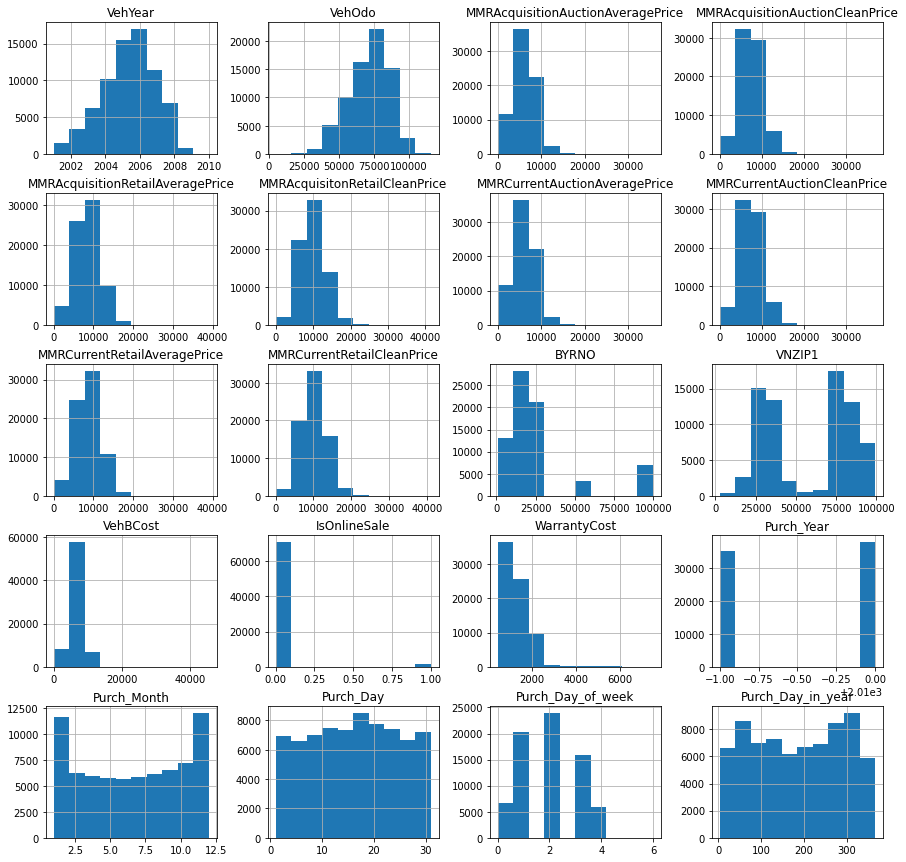

In [33]:
#Let's look at histograms of the numerical features, just as a sanity check
full_features.hist(figsize=(15, 15));

In [34]:
#nothing really jumps out from these histograms. At first I thought we were seeing a lot of sales in the first and last month,
#but that's an artifact of binning 12 months into 10 bins.

<AxesSubplot:>

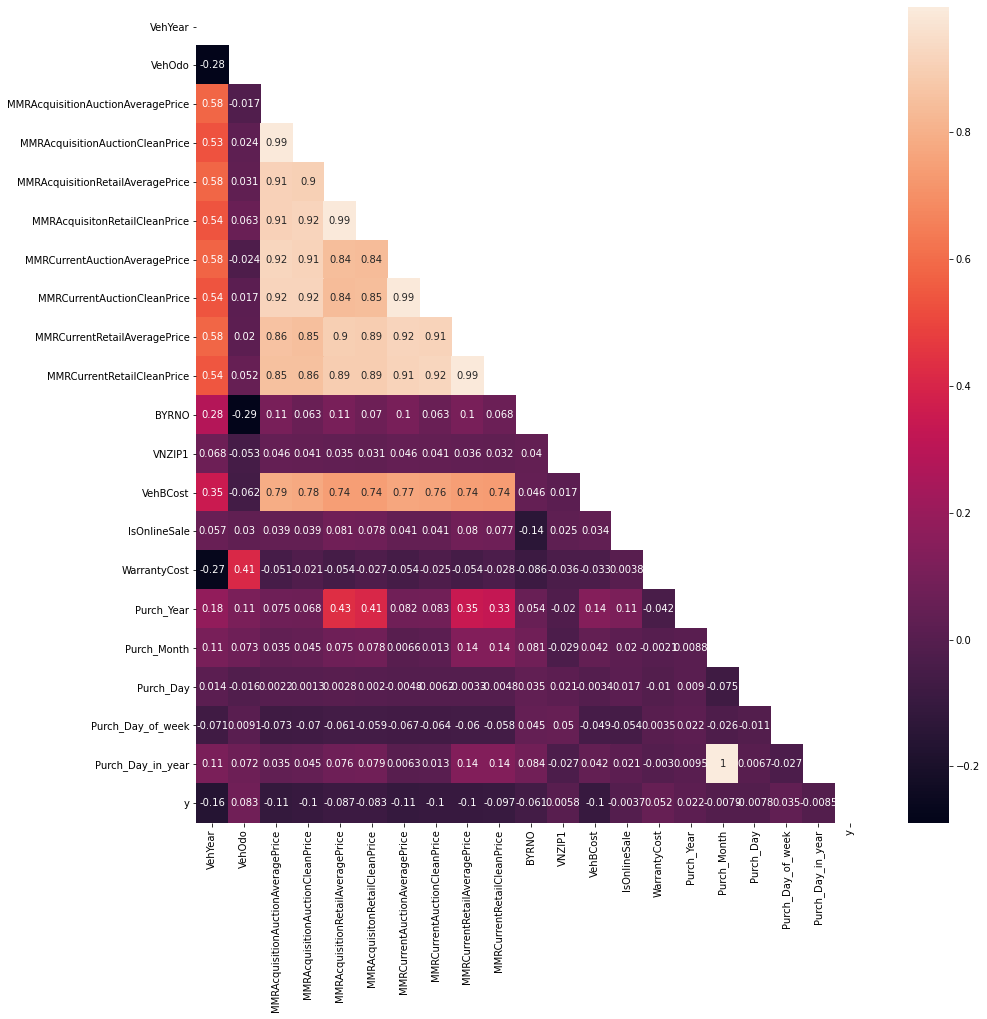

In [35]:
#Now let's look at a correlation matrix of all numerical features and target y
full_features_with_y=full_features.copy()
full_features_with_y['y']=full_y
mask = np.zeros_like(full_features_with_y.corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(15,15))
sns.heatmap(full_features_with_y.corr(),mask=mask, annot=True)

In [36]:
full_features_with_y.corr()['y'].abs().sort_values()

IsOnlineSale                         0.003697
VNZIP1                               0.005796
Purch_Day                            0.007794
Purch_Month                          0.007946
Purch_Day_in_year                    0.008526
Purch_Year                           0.022301
Purch_Day_of_week                    0.035388
WarrantyCost                         0.052319
BYRNO                                0.061488
VehOdo                               0.082560
MMRAcquisitonRetailCleanPrice        0.083425
MMRAcquisitionRetailAveragePrice     0.087198
MMRCurrentRetailCleanPrice           0.097245
VehBCost                             0.099911
MMRCurrentRetailAveragePrice         0.101177
MMRCurrentAuctionCleanPrice          0.101410
MMRAcquisitionAuctionCleanPrice      0.102717
MMRCurrentAuctionAveragePrice        0.106749
MMRAcquisitionAuctionAveragePrice    0.109036
VehYear                              0.158886
y                                    1.000000
Name: y, dtype: float64

The main thing to note in these crosscorrelations is how low the correlations are between the numerical features and the target variable y. This does not bode well for modeling (yes, it's possible to have a good classifier even without strong correlations between single features and the target since we're using non-linear methods that look at multiple features at once, but this is still a bad sign)

# Modeling

In [37]:
#Even though there is already a separate test set, we're going to use train-test-split to make another "test" set,
#and this is the set we'll use to make our model selection. We'll use cross-validation for model tuning.

X_train,X_test,y_train,y_test=train_test_split(full_features_w_dummies,full_y,stratify=full_y,test_size=0.2,random_state=28)

#Note, after going through with the modeling I went back and added this second variation with the numerically mapped
#categorical features. Technically this introduces some data leakage, since information from this constructed test set
#was used to create the numerical encoded features in the training set. Fortunately the best version of the model
#didn't use this numerical encoding, otherwise I would have been more concerned about this and fixed  it.

#If I had more time I would have re-written this code so all the transformations were in functions I could put into a pipeline,
#and have done this train-test-split before any feature engineering/encoding, to avoid data leakage.
X_train2,X_test2,y_train2,y_test2=train_test_split(full_features_w_dummies_numerics,full_y,stratify=full_y,test_size=0.2,random_state=28)



In [38]:
#Gridsearch used for hyper -parameter tuning. Commented out to avoid running when 

# rf = RandomForestClassifier(random_state=42)
# rf_params = {
#     'n_estimators': [100, 200,300],
#     'max_depth': [None, 5,10,20],
#     'min_samples_split' : [2, 5, 10],
# }
# gs = GridSearchCV(rf, param_grid=rf_params,scoring='roc_auc', cv=5)
# gs.fit(X_train, y_train)
# print(gs.best_score_)
# gs.best_params_

Note in the above that I am using ROC-AUC for the scoring metric. I selected this metric because it is robust, does not depend on the specific threshold used, operates on the probabilities. An argument could be made that positive class misclassifcations are more important, and that F1 should be used instead. Fortunately it won't really matter in this case, because the best model is better across both metrics.

In [39]:
#bgs=gs.best_estimator_
bgs=RandomForestClassifier(random_state=28,max_depth=None,n_estimators=300,min_samples_split=10,class_weight='balanced')
bgs.fit(X_train,y_train)
pd.Series(data=bgs.feature_importances_,index=X_train.columns).sort_values(ascending=False).head(20)

WheelTypeID_nan                      0.067375
VehBCost                             0.036715
VehOdo                               0.036612
MMRAcquisitionAuctionAveragePrice    0.036123
MMRCurrentAuctionCleanPrice          0.035635
MMRCurrentAuctionAveragePrice        0.035421
MMRAcquisitionAuctionCleanPrice      0.034633
MMRCurrentRetailAveragePrice         0.033910
MMRCurrentRetailCleanPrice           0.033814
MMRAcquisitionRetailAveragePrice     0.031603
MMRAcquisitonRetailCleanPrice        0.031157
Purch_Day_in_year                    0.029556
BYRNO                                0.027554
WarrantyCost                         0.026653
VNZIP1                               0.025093
Purch_Day                            0.024707
VehYear                              0.024405
WheelTypeID_2.0                      0.023307
Purch_Month                          0.019770
WheelTypeID_1.0                      0.015378
dtype: float64

In [40]:
y_pred=bgs.predict_proba(X_test)

roc_auc_score(y_test,y_pred[:,1])

0.7730565688943972

In [41]:
y_pred=bgs.predict_proba(X_test)

roc_auc_score(y_test,y_pred[:,1])

0.7730565688943972

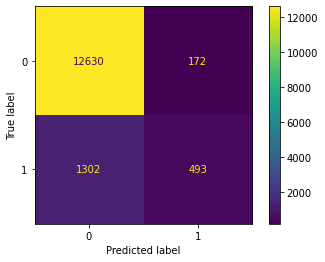

In [42]:
#Confusion tables conveys whole classification performance better than looking at individual metrics
plot_confusion_matrix(bgs,X_test,y_test)

In [43]:
#Not great, way too many false negatives.

In [44]:
#Trying the version with numerical encoding

rf_2=RandomForestClassifier(random_state=28,max_depth=None,n_estimators=300,min_samples_split= 10,)
rf_2.fit(X_train2,y_train2)

RandomForestClassifier(min_samples_split=10, n_estimators=300, random_state=28)

In [45]:
y2_pred=rf_2.predict_proba(X_test2)
roc_auc_score(y_test2,y2_pred[:,1])

0.7681322425682964

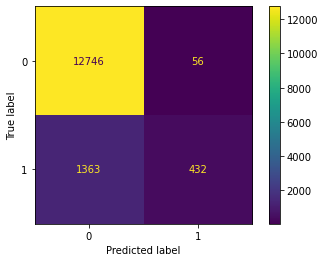

In [46]:
plot_confusion_matrix(rf_2,X_test2,y_test2)

In [47]:
pd.Series(data=rf_2.feature_importances_,index=X_train2.columns).sort_values(ascending=False).head(20)

WheelTypeID_nan                      0.143615
VehBCost                             0.042596
VehOdo                               0.041498
MMRAcquisitionAuctionAveragePrice    0.036169
MMRAcquisitionAuctionCleanPrice      0.035850
MMRCurrentAuctionAveragePrice        0.035512
MMRCurrentAuctionCleanPrice          0.035267
Purch_Day_in_year                    0.034744
MMRCurrentRetailCleanPrice           0.034346
MMRCurrentRetailAveragePrice         0.034329
MMRAcquisitonRetailCleanPrice        0.033991
MMRAcquisitionRetailAveragePrice     0.033865
VNZIP1                               0.028703
WarrantyCost                         0.027981
Purch_Day                            0.027095
Model                                0.026390
BYRNO                                0.026068
WheelTypeID_1.0                      0.023695
SubModel                             0.022218
Purch_Month                          0.019081
dtype: float64

# XGBoost

In [48]:

# xgb = XGBClassifier(random_state=42)
# xgb_params = {
#     'learning_rate': [0.15,0.1,0.05,0.01],
#     'subsample': [0.8,0.9,1],
#     'colsample_bytree' : [0.3,0.5,0.8,0.9],
#     'gamma':[0,1,5]
# }
# gs_xgb = GridSearchCV(xgb, param_grid=xgb_params,scoring='roc_auc', cv=3)
# gs_xgb.fit(X_train, y_train)
# print(gs_xgb.best_score_)
# gs_xgb.best_params_

In [49]:
#best 
#{'colsample_bytree': 0.5, 'gamma': 1, 'learning_rate': 0.1, 'subsample': 0.9}

In [50]:
#b_xgb=gs_xgb.best_estimator_
b_xgb= XGBClassifier(colsample_bytree= 0.5, gamma= 1, learning_rate= 0.1, subsample= 0.9,random_state=42)
b_xgb.fit(X_train,y_train)
pd.Series(data=b_xgb.feature_importances_,index=X_train.columns).sort_values(ascending=False).head(20)

c:\users\matt\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:19:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


WheelTypeID_nan               0.139477
WheelTypeID_1.0               0.057842
WheelTypeID_2.0               0.023483
VehYear                       0.018310
Auction_OTHER                 0.016228
WheelTypeID_3.0               0.015912
Auction_ADESA                 0.014451
Auction_MANHEIM               0.014407
AUCGUART_GREEN                0.007348
AUCGUART_missing              0.006370
PRIMEUNIT_missing             0.006074
PRIMEUNIT_NO                  0.005775
Purch_Year                    0.005730
VNST_NC                       0.005707
Trim_XLT                      0.005524
TopThreeAmericanName_FORD     0.005396
Model_IMPALA V6 3.5L V6 SF    0.004683
Size_MEDIUM SUV               0.004678
VNST_SC                       0.004628
SubModel_4D SUV 4.6L XLT      0.004481
dtype: float32

WheelTypeID_nan was also the most significant feature in the random forest models. This is a bit surprising at first, but perhaps it makes sense that the absence of tire information is highly correlated with a sold car being bad. Below we see that the correlation is indeed higher than anything we saw among the numerical features. And there are over 3000 cars missing this data

In [51]:
#In the EDA section we only looked at correlations with numeric columns, not the categorical

full_features_w_dummies_y=full_features_w_dummies.copy()
full_features_w_dummies_y['y']=full_y
full_features_w_dummies_y[['WheelTypeID_nan','WheelTypeID_1.0','WheelTypeID_2.0' ,'y']].corr()['y'].abs().sort_values()

WheelTypeID_1.0    0.037442
WheelTypeID_2.0    0.117695
WheelTypeID_nan    0.377942
y                  1.000000
Name: y, dtype: float64

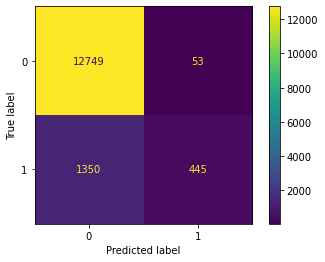

In [52]:
plot_confusion_matrix(b_xgb,X_test,y_test)

In [53]:

y_xg_pred=b_xgb.predict_proba(X_test)
roc_auc_score(y_test,y_xg_pred[:,1])

0.7785254001485666

In [54]:
y_xg_pred_class=b_xgb.predict(X_test)
f1_score(y_test,y_xg_pred_class)

0.38813781072830356

In [55]:
#Trying version with numerical encoding
xgb2 = XGBClassifier(colsample_bytree= 0.5, gamma= 1, learning_rate= 0.1, subsample= 0.9,random_state=42)
xgb2.fit(X_train2, y_train2)

c:\users\matt\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:20:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

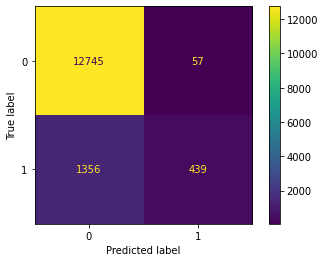

In [56]:
plot_confusion_matrix(xgb2,X_test2,y_test2)

In [57]:
y_xg_pred2=xgb2.predict_proba(X_test2)
roc_auc_score(y_test2,y_xg_pred2[:,1])

0.7752131783030071

In [58]:
# Code for making AUC plot. Adapted from a General Assembly lesson.
def AUC_plot(y_true,y_pred):
    pred_df = pd.DataFrame({'true_values': y_true,
                            'pred_probs':y_pred})

    plt.figure(figsize = (10,7))

    # Create threshold values.
    thresholds = np.linspace(0, 1, 200)

    # Define function to calculate sensitivity. (True positive rate.)
    def TPR(df, true_col, pred_prob_col, threshold):
        true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
        false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
        return true_positive / (true_positive + false_negative)


    # Define function to calculate 1 - specificity. (False positive rate.)
    def FPR(df, true_col, pred_prob_col, threshold):
        true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
        false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
        return 1 - (true_negative / (true_negative + false_positive))

    # Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
    tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
    fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

    # Plot ROC curve.
    plt.plot(fpr_values, # False Positive Rate on X-axis
             tpr_values, # True Positive Rate on Y-axis
             label='ROC Curve')

    # Plot baseline. (Perfect overlap between the two populations.)
    plt.plot(np.linspace(0, 1, 200),
             np.linspace(0, 1, 200),
             label='baseline',
             linestyle='--')

    # Label axes.
    plt.title('Receiver Operating Characteristic Curve', fontsize=22)
    plt.ylabel('Sensitivity', fontsize=18)
    plt.xlabel('1 - Specificity', fontsize=18)

    # Create legend.
    plt.legend(fontsize=16);

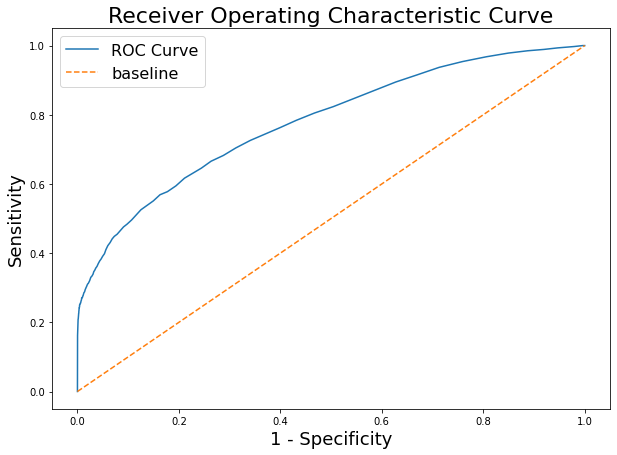

In [59]:
AUC_plot(y_test,y_xg_pred[:,1])

# Model Selection and Discussion

Across the four main models that we've looked at, dummy vs numerical encoding and random forest vs xgboost, the best version by both ROC AUC and the confusion matrix (and thus f1 score) is the xgboost with the dummy encoding.

The model isn't great though, as shown in the confusion matrix below. In particular it has a poor false negative (type 2 error) rate of about 75%, it's only correctly finding 25% of the bad cars in the created test set. On the positive side though it has a very small false positive rate, 0.4%. But that doesn't make up for missing 3/4 of the lemons.

Going forward, the best way to improve the model is likely through more feature engineering and bringing in external data, specifically use the zip code along with demographic data (or other available data, maybe crime statistics). This geographic based information can be very useful in models, and right now we're not using any of it.

There may also be more car specific information to bring in, likely being linked via model or submodel.  

Better handling of the large categories could also help, cutting down on the number of models by  grouping similar cars together (either based on name, expert knowledge, or maybe by clustering)

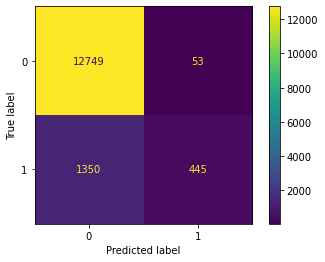

In [60]:
plot_confusion_matrix(b_xgb,X_test,y_test)

In [61]:
#Generating predictions with the true test set. Need column order to match
test_features_w_dummies = test_features_w_dummies[X_test.columns]
y_xg_pred_class=b_xgb.predict(test_features_w_dummies)

In [63]:
test_predictions_df=pd.DataFrame(data={'RefId':full_test['RefId'],'IsBadBuy':y_xg_pred_class})
#test_predictions_df.to_csv('haney_test_predictions.csv',index=False)